In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import asarray
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.utils.np_utils import to_categorical
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, utils
!pip install numpy==1.19.5

In [2]:
df = pd.read_csv('../../data/anonymized_bsc_dataPVZ.csv')

/Users/clementinelacey/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (18,20,21,23,24,26,27,29,31,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
0,15/SP,DA 101 A,Basic Ballet,F,0.5,3.0,W,3.0,3.667,Melissa Turnage,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
1,15/SP,HI 155 A-ES,Reforming America,F,1.0,NaN,A-,3.0,3.667,Victoria Ott,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
2,15/SP,PL 200 A-CI,Ethical Choice,F,1.0,NaN,B+,3.0,3.667,William Myers,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
3,15/SP,IDS 200 A-CI,Intro to Human Rights (GP),F,1.0,NaN,A,3.0,3.667,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology
4,15/WI,GEN E299 49,Exploration Project,F,1.0,1.0,S,1.0,0.000,Vincent Gawronski,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,18/SP,1718.0,Psychology


# Preprocessing

In [4]:
#changing nomenclature for term so that we can sort in chronological order by that column
df['Sttr Term'] = df['Sttr Term'].replace({'WI':'A','SP':'B', 'SU':'C', 'FA':'D'}, regex=True)
#dropping completely null rows
df.drop(df.index[51518:51537], inplace=True)
#isolating students who would have been able to graduate in the timeframe of our given data
df = df.loc[(df['Cohort'] == '14/FA') | (df['Cohort'] == '15/FA') | (df['Cohort'] == '16/FA')
              | (df['Cohort'] == '17/FA')]
df = df.dropna(subset=['Sttr Term'])
df['alt_id'] = df['alt_id'].astype(int)
#encoding our target
mapping = {'N': 0, 'Y': 1}
df['Graduated'] = df['Graduated'].map(mapping)
data = df.sort_values(['Sttr Term'], ascending=True)
data.head()

,Sttr Term,course_#,course_title,Sttr Student Load,Sttr Stu Credits,Sttr Attempted Cred,Sttr Stu Final Grades,Sttr Cmpl Cred,Sttr Term Gpa,faculty,...,FA5 Enr,FA5 Class,FA5 Major,FA6 Enr,FA6 Class,FA6 Major,Graduated,Grad Term,Grad Year,Grad Major
6784,14/D,EH 208 B,Intermediate Writing,F,1.00,NaN,F,1.00,1.110,Sandra Sprayberry,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Urban Environmental Studies
7369,14/D,BI 115 A-SM,Organismal Biology,F,1.00,3.0,F,1.00,0.557,Andrew Gannon,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
7370,14/D,PY 101 F,Introduction to Psychology,F,1.00,NaN,C-,1.00,0.557,Gabrielle Smith,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
7371,14/D,EH 102 C,Sem Critical Thinking Writing,F,1.00,NaN,F,1.00,0.557,Steven Carter,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1114,14/D,MS 120 D,Voice,F,0.25,NaN,A,3.25,3.591,Erin Ludwick,...,NaN,NaN,NaN,NaN,NaN,NaN,1,18/SP,1718.0,Biology


# EDA

In [5]:
#investigating how many classes students are taking to find outliers
df.alt_id.value_counts(ascending=False)

1139    64
1469    62
2046    62
1002    62
2328    60
        ..
2030     3
2516     3
1732     3
1191     3
1857     3
Name: alt_id, Length: 1455, dtype: int64

In [6]:
#Checking for Course Title Duplicates
df['course_title'].nunique()

952

# Modeling

## Course Sequential Model

In [7]:
#target = []
#student_ids = df.alt_id.unique()
#for s_id in student_ids:
 #   grad = df[df['alt_id'] == s_id].iloc[0].Graduated
  #  target.append(grad)

In [29]:
#Baseline Course Sequence
def course_modeling(df, N, E):
    target = []
    course_sequences = []
    student_ids = df.alt_id.unique()
    for s_id in student_ids:
        grad = df[df['alt_id'] == s_id].iloc[0].Graduated
        target.append(grad)
    for s_id in student_ids:
        frame = df[df['alt_id'] == s_id]
        course_ids = ' '.join(frame.course_title.str.replace(' ', '').to_list())
        course_sequences.append(course_ids)
        
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(course_sequences)
    #Tozenizing course sequences to prepare for model
    encoded_sequences = tokenizer.texts_to_sequences(course_sequences)
    #Accounting for students with many more courses
    padded_course_sequences = pad_sequences(encoded_sequences, maxlen=N, dtype='int32', padding='post',
    truncating='post', value=0.0)
    padded_reshaped_courses = padded_course_sequences.reshape(1455, N, 1)

    model = Sequential()
    input_layer = Input(shape=(N, 1))
    sequential_1 = LSTM(64, activation='relu')
    output_layer = Dense(1, activation='sigmoid')

    model.add(input_layer)
    model.add(sequential_1)
    model.add(output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    model.fit(padded_reshaped_courses, np.array(target), epochs=E, validation_split = .2)
    
     #plot
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='Train')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='Validation')
    
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='Train')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='Validation')
    
    ax2.legend()

### Baseline - Full Course Sequence

Epoch 1/10
37/37 [==============================] - 1s 19ms/step - loss: 272.3036 - accuracy: 0.3419 - val_loss: 240.1660 - val_accuracy: 0.4880
Epoch 2/10
37/37 [==============================] - 1s 14ms/step - loss: 567.6304 - accuracy: 0.5567 - val_loss: 1215.5796 - val_accuracy: 0.5052
Epoch 3/10
37/37 [==============================] - 0s 12ms/step - loss: 1629.9021 - accuracy: 0.4871 - val_loss: 384.2589 - val_accuracy: 0.3952
Epoch 4/10
37/37 [==============================] - 0s 12ms/step - loss: 269.8215 - accuracy: 0.4381 - val_loss: 104.0456 - val_accuracy: 0.5704
Epoch 5/10
37/37 [==============================] - 0s 12ms/step - loss: 86.9581 - accuracy: 0.5842 - val_loss: 120.0275 - val_accuracy: 0.5326
Epoch 6/10
37/37 [==============================] - 0s 12ms/step - loss: 114.4770 - accuracy: 0.5816 - val_loss: 72.8092 - val_accuracy: 0.5361
Epoch 7/10
37/37 [==============================] - 0s 12ms/step - loss: 105.9115 - accuracy: 0.4424 - val_loss: 95.4736 - val_acc

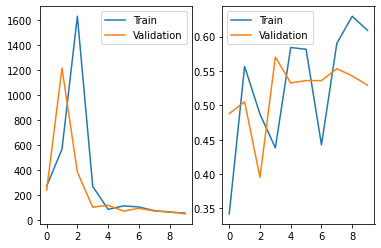

In [30]:
#Full Term
fullcoursemodel = course_modeling(data,45,10)

### First Semester Freshman Year

Epoch 1/20
37/37 [==============================] - 0s 7ms/step - loss: 1.2292 - accuracy: 0.5971 - val_loss: 0.8822 - val_accuracy: 0.4983
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.7630 - accuracy: 0.6280 - val_loss: 0.7745 - val_accuracy: 0.5258
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6409 - val_loss: 0.7876 - val_accuracy: 0.5155
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6607 - val_loss: 0.7486 - val_accuracy: 0.5464
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6675 - val_loss: 0.7634 - val_accuracy: 0.5739
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6641 - val_loss: 0.7887 - val_accuracy: 0.5704
Epoch 7/20
37/37 [==============================] - 0s 2ms/step - loss: 0.6241 - accuracy: 0.6701 - val_loss: 0.7621 - val_accuracy: 0.5533
Epoch 8/20
37/37 [==

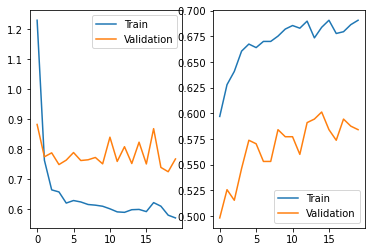

In [31]:
#First Semester Freshman
course_modeling(data,4,20)

### After Sophomore Year

Epoch 1/15
37/37 [==============================] - 0s 10ms/step - loss: 1.9420 - accuracy: 0.7105 - val_loss: 1.6227 - val_accuracy: 0.7251
Epoch 2/15
37/37 [==============================] - 0s 5ms/step - loss: 0.9061 - accuracy: 0.7947 - val_loss: 0.9087 - val_accuracy: 0.7045
Epoch 3/15
37/37 [==============================] - 0s 5ms/step - loss: 0.6642 - accuracy: 0.8093 - val_loss: 0.9012 - val_accuracy: 0.7354
Epoch 4/15
37/37 [==============================] - 0s 5ms/step - loss: 0.5496 - accuracy: 0.8299 - val_loss: 0.7410 - val_accuracy: 0.7560
Epoch 5/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4785 - accuracy: 0.8385 - val_loss: 0.8421 - val_accuracy: 0.7663
Epoch 6/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4826 - accuracy: 0.8402 - val_loss: 0.7896 - val_accuracy: 0.7388
Epoch 7/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4518 - accuracy: 0.8436 - val_loss: 0.6510 - val_accuracy: 0.7595
Epoch 8/15
37/37 [=

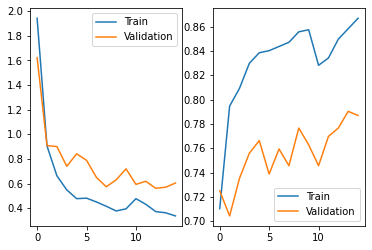

In [32]:
#Sophomore
course_modeling(data,16,15)

## Baseline Sequential Grades Model

In [33]:
#baseline grades
def grade_modeling(df,N,E):
    student_ids = df.alt_id.unique()
    target = []
    for s_id in student_ids:
        grad = df[df['alt_id'] == s_id].iloc[0].Graduated
        target.append(grad)
    grade_sequences = []
    for s_id in student_ids:
        frame = df[df['alt_id'] == s_id]
        grades = ' '.join(frame['Sttr Stu Final Grades'].to_list())
        grade_sequences.append(grades)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(grade_sequences)
    encoded_sequences = tokenizer.texts_to_sequences(grade_sequences)
    padded_grade_sequences = pad_sequences(
    encoded_sequences, maxlen=N, dtype='int32', padding='post',
    truncating='post', value=0.0)
    padded_reshaped_grades = padded_grade_sequences.reshape(1455, N, 1)

    model = Sequential()
    input_layer = Input(shape=(N, 1))
    sequential_1 = LSTM(64, activation='relu')
    output_layer = Dense(1, activation='sigmoid')

    model.add(input_layer)
    model.add(sequential_1)
    model.add(output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    model.fit(padded_reshaped_grades, np.array(target), epochs=E, validation_split = .2)
    
    accuracy = model.history.history['accuracy']
    print(round(accuracy[-1],2))
    
     #plot
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='Train')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='Validation')
    
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='Train')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='Validation')
    
    ax2.legend()
    
    #loss = model.history.history['loss']
   # print(round(loss[-1],2))

#pd.DataFrame(feature_encoder.transform(np.array(padded_grade_sequences[0]).reshape(-1,1)).todense())
#np.array(padded_grade_sequences[0]).reshape(-1,1)












### Baseline -- Full Course Sequence

Epoch 1/10
37/37 [==============================] - 1s 17ms/step - loss: 0.6562 - accuracy: 0.6237 - val_loss: 0.6655 - val_accuracy: 0.5601
Epoch 2/10
37/37 [==============================] - 0s 12ms/step - loss: 0.5836 - accuracy: 0.6641 - val_loss: 0.6129 - val_accuracy: 0.5601
Epoch 3/10
37/37 [==============================] - 0s 13ms/step - loss: 0.4329 - accuracy: 0.7139 - val_loss: 0.4821 - val_accuracy: 0.8110
Epoch 4/10
37/37 [==============================] - 0s 13ms/step - loss: 0.2597 - accuracy: 0.9399 - val_loss: 0.3107 - val_accuracy: 0.8935
Epoch 5/10
37/37 [==============================] - 1s 14ms/step - loss: 0.2283 - accuracy: 0.9235 - val_loss: 0.4109 - val_accuracy: 0.8351
Epoch 6/10
37/37 [==============================] - 0s 13ms/step - loss: 0.4373 - accuracy: 0.9270 - val_loss: 1.2190 - val_accuracy: 0.6873
Epoch 7/10
37/37 [==============================] - 0s 13ms/step - loss: 0.3822 - accuracy: 0.9149 - val_loss: 0.3903 - val_accuracy: 0.9003
Epoch 8/10
37

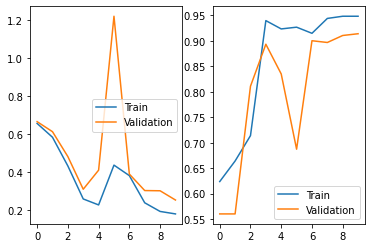

In [34]:
#Full Course - 45 classes
grade_modeling(data,45,10)

### First Semester Freshman Year Grades

Epoch 1/15
37/37 [==============================] - 0s 7ms/step - loss: 0.6708 - accuracy: 0.6641 - val_loss: 0.7044 - val_accuracy: 0.5601
Epoch 2/15
37/37 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6658 - val_loss: 0.6637 - val_accuracy: 0.6117
Epoch 3/15
37/37 [==============================] - 0s 2ms/step - loss: 0.6145 - accuracy: 0.6924 - val_loss: 0.5963 - val_accuracy: 0.6529
Epoch 4/15
37/37 [==============================] - 0s 2ms/step - loss: 0.5888 - accuracy: 0.7122 - val_loss: 0.5679 - val_accuracy: 0.6804
Epoch 5/15
37/37 [==============================] - 0s 2ms/step - loss: 0.5889 - accuracy: 0.7027 - val_loss: 0.5742 - val_accuracy: 0.6804
Epoch 6/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5935 - accuracy: 0.7079 - val_loss: 0.5821 - val_accuracy: 0.6770
Epoch 7/15
37/37 [==============================] - 0s 2ms/step - loss: 0.5835 - accuracy: 0.7105 - val_loss: 0.5698 - val_accuracy: 0.6838
Epoch 8/15
37/37 [==

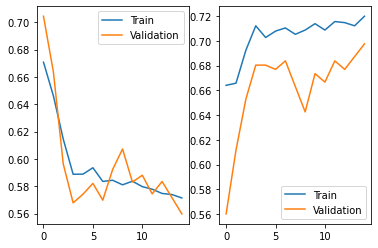

In [36]:
#Freshman 1st Semester
grade_modeling(data,4,15)

### After Sophomore Year

Epoch 1/15
37/37 [==============================] - 0s 10ms/step - loss: 0.5999 - accuracy: 0.7758 - val_loss: 0.5962 - val_accuracy: 0.7801
Epoch 2/15
37/37 [==============================] - 0s 6ms/step - loss: 0.4634 - accuracy: 0.8531 - val_loss: 0.5302 - val_accuracy: 0.7869
Epoch 3/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4116 - accuracy: 0.8591 - val_loss: 0.5035 - val_accuracy: 0.8041
Epoch 4/15
37/37 [==============================] - 0s 5ms/step - loss: 0.4011 - accuracy: 0.8582 - val_loss: 0.4920 - val_accuracy: 0.7973
Epoch 5/15
37/37 [==============================] - 0s 6ms/step - loss: 0.3731 - accuracy: 0.8694 - val_loss: 0.4552 - val_accuracy: 0.8076
Epoch 6/15
37/37 [==============================] - 0s 5ms/step - loss: 0.3462 - accuracy: 0.8711 - val_loss: 0.3960 - val_accuracy: 0.8247
Epoch 7/15
37/37 [==============================] - 0s 6ms/step - loss: 0.3237 - accuracy: 0.8754 - val_loss: 0.3887 - val_accuracy: 0.8247
Epoch 8/15
37/37 [=

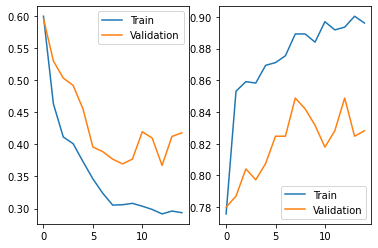

In [39]:
#Sophomore
grade_modeling(data,16,15)